In [ ]:
!pip install -q transformers datasets
!pip install -q transformers==4.23.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import Libraries

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
pip install git+https://github.com/huggingface/datasets

  Cloning https://github.com/huggingface/datasets to /tmp/pip-req-build-64dskfm6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/datasets /tmp/pip-req-build-64dskfm6
  Resolved https://github.com/huggingface/datasets to commit c5464b32ce03739431235c13f314732201abcfac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for datasets: filename=datasets-2.20.1.dev0-py3-none-any.whl size=522358 sha256=e50767ee743735cd5da9b4f098485c3a07da66ab6a5925656b83730f6a2dd39e
  Stored in directory: /tmp/pip-ephem-wheel-cache-cfxe3uf4/wheels/7f/ba/ce/8f6a52388a9966c7d9afa987113a763f7c105f568f369adbc6
Successfully built datasets
  Attempting uninstall: datasets
    Found existing installation: datasets 2.20.0
    Uninstalling datasets-2.20.0:
      Successfully uninstalled datasets-2.20.0


# Read the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = load_dataset("imagefolder", data_files= "/content/drive/MyDrive/CourseMaterial/Supervised Machine Learning/Vision Transformer/CatDog.zip", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

# Observe the dataset


In [ ]:
data

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})

# Splt the dataset

In [ ]:
split = data.train_test_split(test_size=0.2)

In [ ]:
split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})

# Further split the test part to get the validation part

In [ ]:
split02 = split['test'].train_test_split(test_size=0.5)

In [ ]:
split02

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
})

In [ ]:
train_ds = split['train']

In [ ]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 800
})

In [ ]:
test_ds = split02['test']
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})

In [ ]:
val_ds = split02['train']
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})

# Check the example of the training dataset

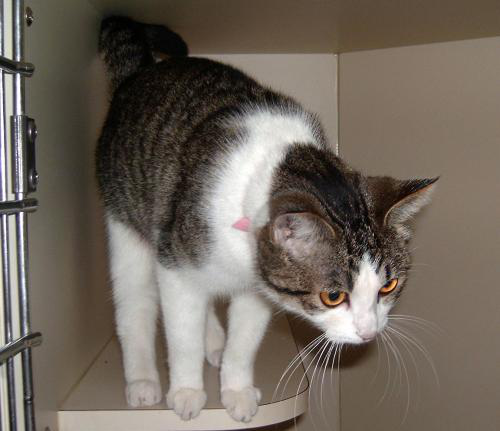

In [ ]:
train_ds[0]['image']

In [ ]:
train_ds[0]['label']

0

# Create index to label and label to index dictionaries

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'cat', 1: 'dog'}

# Import the feature extractor

In [ ]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Apply transforms to dataset for data augmentation, normalization and resizing

In [ ]:
from torchvision.transforms import (ToTensor,
                                    CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [   ToTensor(),
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            #ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            ToTensor(),
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            #ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Apply the transforms on training, testing and validation sets

In [ ]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

# Create pytorch dataloader

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# Import Pretrained ViT Image Classifier

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=2,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Set the Training Arguments

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

C:\Users\USER\AppData\Local\Temp/ipykernel_12212/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"cat-dog",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

## Train the model

In [ ]:
trainer.train()

D:\Anaconda\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 2
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 160


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.085623,0.980000
2,No log,0.058983,0.990000


***** Running Evaluation *****
  Num examples = 100
  Batch size = 4
Saving model checkpoint to cat-dog\checkpoint-80
Configuration saved in cat-dog\checkpoint-80\config.json
Model weights saved in cat-dog\checkpoint-80\pytorch_model.bin
Feature extractor saved in cat-dog\checkpoint-80\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 100
  Batch size = 4
Saving model checkpoint to cat-dog\checkpoint-160
Configuration saved in cat-dog\checkpoint-160\config.json
Model weights saved in cat-dog\checkpoint-160\pytorch_model.bin
Feature extractor saved in cat-dog\checkpoint-160\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from cat-dog\checkpoint-160 (score: 0.99).


TrainOutput(global_step=160, training_loss=0.09313488006591797, metrics={'train_runtime': 95.4563, 'train_samples_per_second': 16.762, 'train_steps_per_second': 1.676, 'total_flos': 1.239871833833472e+17, 'train_loss': 0.09313488006591797, 'epoch': 2.0})

# Test the model

In [ ]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 100
  Batch size = 4


#  Display confusion matrix and find the accuracy

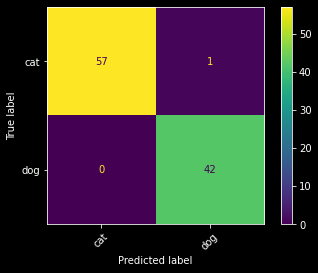

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
Accuracy = accuracy_score(y_true, y_pred, normalize=True).round(3)

In [ ]:
Accuracy

0.99